# 인퍼런스 뽑기

## 모델 로딩

In [44]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import ASTConfig, ASTModel, GPT2Config, GPT2Model, AutoModelForCausalLM, GPT2LMHeadModel

class GPT2Model(nn.Module):
    def __init__(self, vocab_size=140):
        super(GPT2Model, self).__init__()
        self.configuration = GPT2Config(vocab_size=vocab_size, bos_token_id=2, eos_token_id=1)
        self.model = GPT2LMHeadModel(self.configuration)
        
        # self.optimizer = Adam(self.model.parameters(), lr=3e-5)
        # self.scheduler = optim.lr_scheduler.LambdaLR(optimizer=self.optimizer, lr_lambda=lambda epoch: 0.97 ** epoch)
    
    def forward(self, input_ids, labels=None):
        attention_mask = self.make_mask(input_ids)
        output = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return output
    
    def make_mask(self, input_ids):
        attention_mask = (input_ids != 0).long()
        return attention_mask
    
    def infer(self, input_ids, length=2048):
        if len(input_ids.shape) == 1:
            input_ids = input_ids.unsqueeze(0)
        if len(input_ids.shape) > 2:
            raise Exception
        
        if length > 2048:
            print("Max Length is 2048. Change Length Auto to 2048")
            length = 2048
        
        with torch.no_grad():
            for step in range(length):
                output = self.forward(input_ids)
                output = torch.argmax(output.logits, dim=2)

                predict = output[:,-1].unsqueeze(1)
                output_ids = torch.cat((input_ids, predict), dim=-1)

                input_ids = output_ids

                value = predict.item()
                if value == 1:
                    break
                
                # if torch.all(predict.eq(0)):
                #     break
                
                if output_ids.shape[1] > 2048:
                    print("LONG FIN")
                    break

        return output_ids


vocab_size = 150
device = torch.device("cuda:8" if torch.cuda.is_available() else "cpu")
print(device)

base_model = 'GPT2'
model = GPT2Model(vocab_size=vocab_size).to(device)
model.load_state_dict(torch.load('/workspace/pj/out/chord_bpe/GPT2_BPE_V150/model_207_0.4520_0.3645.pt', map_location=device))

cuda:8


<All keys matched successfully>

# Test Set 로딩

In [7]:
import torch
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

class BPE_Chord_Dataset(Dataset):
    def __init__(self, data, base_model):
        super().__init__()
        self.data = data
        self.base_model = base_model
        # TODO
        vocab_path = '/workspace/pj/data/vocabs/chord.json'
        print(f'Open Data {vocab_path[-11:]}')
        with open(vocab_path, 'r') as file:
            self.vocab = json.load(file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text_seq = self.data[idx]
        
        if isinstance(text_seq, str):
            toks = text_seq.split()
        l_toks = len(toks)
        ratio = 4
        chord_list = []
        for idx in range(0, l_toks, ratio):
            t1, t2, t3, t4 = toks[idx : idx + 4]
            if t1[0] == 'h' or t1[0] == 'H':
                chord_list.append(t1)
                
        target_chord_seq = self.tokenizing_chord_seq(chord_list)
        # target_chord_seq = [i for i in range(10,110)]
        # target_chord_tensor = [2] + target_chord_seq[:510] + [1]
        target_chord_tensor = [2] + target_chord_seq[:510] + [1]
        
        target_chord_tensor = torch.tensor(target_chord_tensor)
        
        return target_chord_tensor
    
    def tokenizing_chord_seq(self, chord_list):
        cur = 0
        cur_chord = chord_list[0]
        candidate = 1
        group_list = []
        while(cur < len(chord_list) and candidate < len(chord_list)):
            
            if cur_chord + chord_list[candidate] in self.vocab:
                cur_chord += chord_list[candidate]
                candidate += 1
                continue
            else:
                group_list.append(self.vocab[cur_chord])
                cur_chord = chord_list[candidate]
                cur = candidate
                candidate += 1
        group_list.append(self.vocab[cur_chord])
            
        return group_list
    
    
    
def create_BPE_dataloaders(batch_size, base_model):
    # chord_data = torch.load('../../../workspace/data/tensor/chord_tensor.pt')
    raw_data_path = '../../../workspace/pj/data/corpus/raw_corpus_bpe.txt'
    raw_data = []
    with open(raw_data_path, 'r') as f:
        for line in tqdm(f, desc="reading original txt file..."):
            raw_data.append(line.strip())
            
    # train, val_test = train_test_split(chord_data, test_size=0.1, random_state=5)
    train, val_test = train_test_split(raw_data, test_size=0.1, random_state=5)
    val, test = train_test_split(val_test, test_size=0.2, random_state=5)
    
    train_dataset = BPE_Chord_Dataset(train, base_model)
    val_dataset = BPE_Chord_Dataset(val, base_model)
    test_dataset = BPE_Chord_Dataset(test, base_model)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=BPE_collate_batch)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=BPE_collate_batch)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=BPE_collate_batch)

    return train_loader, val_loader, test_loader

def BPE_collate_batch(batch):
    padded = pad_sequence(batch, padding_value=0, batch_first=True)
    # return padded[:,:-1], padded[:,1:]
    return padded, padded


train_loader, val_loader, test_loader = create_BPE_dataloaders(1, 'GPT2')
print(f'Split Train : {len(train_loader.dataset)}, Val : {len(val_loader.dataset)}, Test : {len(test_loader.dataset)}')

reading original txt file...: 362it [00:00, 3617.58it/s]

reading original txt file...: 46188it [00:13, 3456.86it/s]


Open Data /chord.json
Open Data /chord.json
Open Data /chord.json
Split Train : 41569, Val : 3695, Test : 924


# Test Set 으로 Inference (5마디 Prompt)

In [45]:
model_infer_chord = []
cnt = 0
for (inputs, targets) in tqdm(test_loader, ncols=80):
    seq_len = inputs.shape[1]
    # print(seq_len)
    if seq_len < 5:
        print("SHORT ERROR")
        continue
    
    inputs = inputs[:,:5].to(device)
    
    out = model.infer(inputs, length=1024)
    
    model_infer_chord.append(out)

100%|█████████████████████████████████████████| 924/924 [33:43<00:00,  2.19s/it]


In [46]:
print(len(model_infer_chord))

924


In [65]:
import torch
import pickle

# Example list of tensors
tensor_list = [
    torch.tensor([[116]], device='cuda:8'),
    torch.tensor([[1]], device='cuda:8'),
    torch.tensor([[200]], device='cuda:8')
]

# File name to save the list
file_name = '/workspace/pj/out/infer_gpt_output.pkl'

# Saving the list with pickle
with open(file_name, 'wb') as f:
    pickle.dump(model_infer_chord, f)

print(f'Tensor list saved to {file_name}')


Tensor list saved to /workspace/pj/out/infer_gpt_output.pkl


In [79]:
import pickle

# File name where the list was saved
file_name = '/workspace/pj/out/infer_gpt_output.pkl'

# Loading the list with pickle
with open(file_name, 'rb') as f:
    model_infer_chord = pickle.load(f)

print(len(model_infer_chord))


924


# 타겟 뽑기

In [25]:
target_length = []
target_chord = []

for (inputs, targets) in tqdm(test_loader, ncols=80):
    seq_len = inputs.shape[1]
    
    target_length.append(seq_len)
    target_chord.append(inputs)

print(len(target_chord))
print(len(target_length))

100%|█████████████████████████████████████████| 924/924 [00:11<00:00, 79.40it/s]

924
924


# 비교군 베이스라인 뽑기

In [27]:
# Initialize an empty list to store the lines
gen_txt = []

# Open the file in read mode
with open('/workspace/pj/out/short_answer_output.txt', 'r') as file:
    # Read each line from the file
    for line in file:
        # Strip newline characters and add to the list
        gen_txt.append(line.strip())

# Print the list to verify its contents
print(len(gen_txt))

import ast
gen_chord = []

for idx, gen in tqdm(enumerate(gen_txt)):
    
    try:
        to_list = ast.literal_eval(gen)
    except:
        gen_chord.append([])
        continue
        print(idx)
        print(gen)
    
    c_list = []
    for seq in to_list:
        if seq[0] == 'h' or seq[0] == 'H':
            c_list.append(seq)
    gen_chord.append(c_list)

924


924it [01:09, 13.29it/s]


In [29]:
print(len(gen_chord))

924


# 각각 Count하기

In [30]:
vocab_path = '/workspace/pj/data/vocabs/chord.json'
with open(vocab_path, 'r') as file:
    vocab_chord = json.load(file)

In [59]:
target_cnt = [0] * 138
infer_cnt = [0] * 138
base_cnt = [0] * 138

for chord in model_infer_chord:
    for c in chord[0]:
        value = c.item()
        infer_cnt[value] += 1

for chord in target_chord:
    for c in chord[0]:
        value = c.item()
        target_cnt[value] += 1

In [60]:
for chord in gen_chord:
    for c in chord:
        base_cnt[vocab_chord[c]] += 1
print(base_cnt)

[0, 0, 0, 98, 2536, 376, 681, 346, 219, 1, 271, 41, 248, 2, 33, 884, 141, 323, 151, 241, 2, 65, 7, 406, 5, 126, 2810, 251, 897, 471, 287, 1, 233, 43, 201, 4, 60, 1664, 267, 276, 128, 182, 2, 154, 22, 51, 6, 69, 1709, 142, 771, 366, 296, 0, 156, 25, 83, 1, 104, 2151, 428, 453, 223, 183, 2, 226, 39, 42, 4, 26, 889, 90, 415, 222, 206, 3, 76, 15, 76, 0, 143, 2688, 309, 880, 421, 147, 2, 284, 39, 40, 2, 38, 948, 204, 224, 87, 120, 0, 110, 9, 62, 5, 99, 1957, 167, 884, 410, 199, 0, 220, 25, 88, 1, 81, 1501, 311, 232, 157, 102, 1, 164, 37, 45, 11, 48, 920, 137, 510, 282, 192, 5, 55, 21, 5119, 258, 5, 0, 0]


In [49]:
print(infer_cnt)

[0, 924, 924, 388, 8019, 938, 2217, 905, 347, 0, 377, 79, 281, 6, 87, 1793, 280, 646, 315, 817, 3, 101, 20, 512, 4, 354, 7427, 739, 2792, 1226, 423, 2, 352, 72, 192, 3, 182, 4486, 710, 829, 367, 321, 0, 192, 45, 59, 32, 174, 3172, 259, 2075, 1004, 431, 3, 174, 53, 109, 0, 219, 6415, 891, 1368, 727, 266, 0, 533, 65, 47, 33, 117, 1894, 244, 1059, 420, 307, 1, 96, 20, 119, 0, 303, 7920, 935, 3007, 1018, 374, 2, 461, 51, 57, 0, 57, 2578, 602, 426, 231, 209, 2, 141, 19, 121, 4, 286, 3883, 337, 2343, 1030, 359, 2, 249, 89, 109, 0, 227, 4719, 773, 1024, 362, 189, 2, 292, 65, 65, 15, 131, 2103, 224, 1622, 766, 549, 20, 102, 34, 4491, 444, 5, 0, 0]


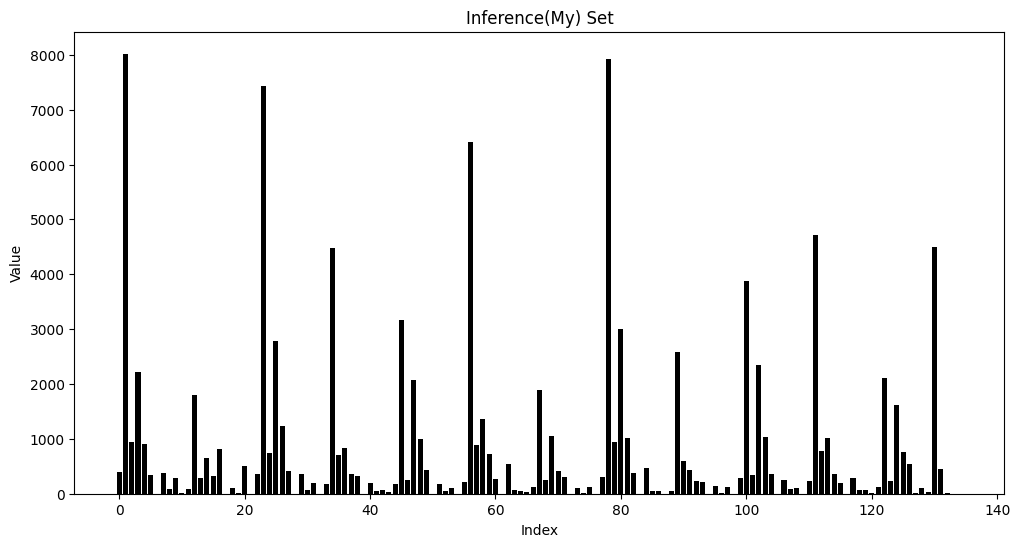

In [68]:
import matplotlib.pyplot as plt
# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(infer_cnt[3:])), infer_cnt[3:], color='black')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Inference(My) Set')
plt.show()


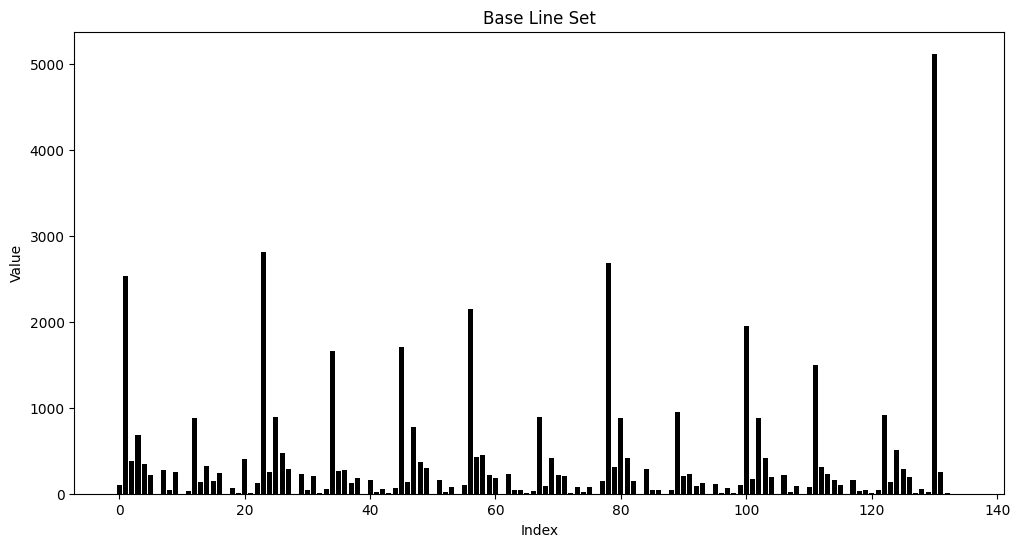

In [67]:
import matplotlib.pyplot as plt
# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(base_cnt[3:])), base_cnt[3:], color='black')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Base Line Set')
plt.show()


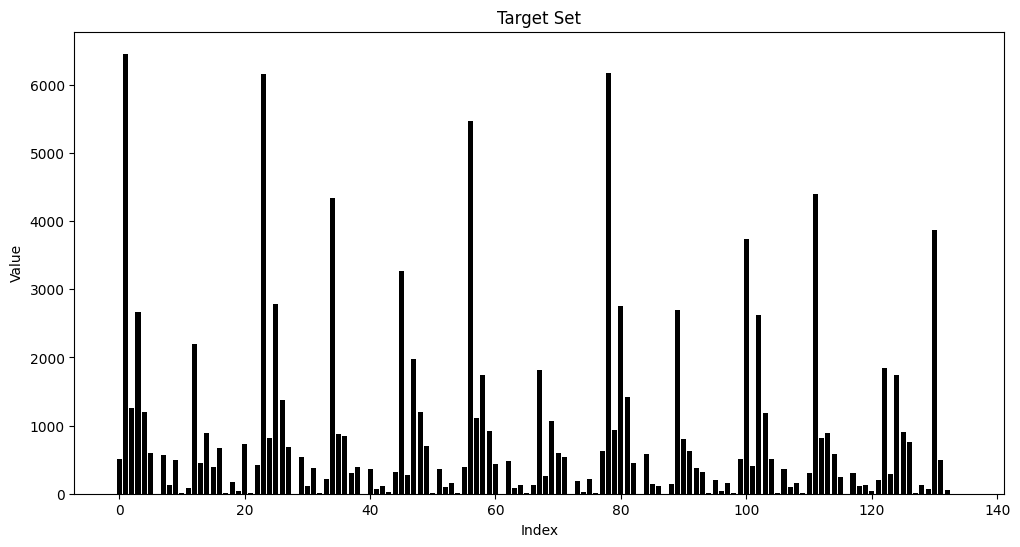

In [70]:
import matplotlib.pyplot as plt
# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(target_cnt[3:])), target_cnt[3:], color='black')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Target Set')
plt.show()


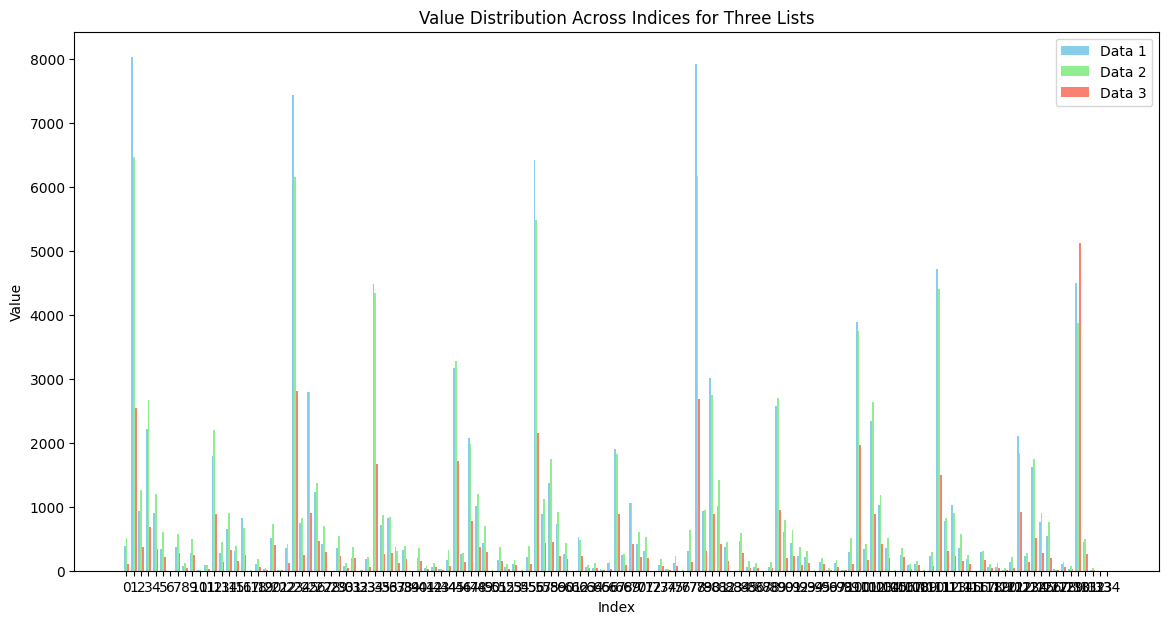

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Example lists of values
data1 = [0, 924, 924, 512, 6459, 1256, 2672, 1198, 605, 0, 573, 122, 489, 5, 83]
data2 = [5, 600, 700, 512, 1024, 2300, 3500, 1500, 750, 5, 623, 133, 509, 10, 100]
data3 = [2, 300, 624, 400, 7000, 2000, 4500, 900, 800, 2, 500, 120, 700, 15, 120]

# Number of elements in each list
N = len(infer_cnt[3:])

# Create an array for the indices
indices = np.arange(N)

# Width of the bars
width = 0.25

# Plotting
plt.figure(figsize=(14, 7))
plt.bar(indices, infer_cnt[3:], width=width, color='skyblue', label='Data 1')
plt.bar(indices + width, target_cnt[3:], width=width, color='lightgreen', label='Data 2')
plt.bar(indices + 2*width, base_cnt[3:], width=width, color='salmon', label='Data 3')

# Labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Value Distribution Across Indices for Three Lists')
plt.xticks(indices + width, indices)  # Center the x-ticks
plt.legend()

# Show plot
plt.show()


In [90]:
t_l = [0] * 513

for chord in gen_chord:
    print(len(chord))
    t_l[len(chord)] += 1

52
24
94
33
50
47
45
65
29
98
36
90
52
93
64
70
42
34
32
50
89
13
42
108
52
30
28
50
36
76
52
33
16
44
45
72
26
52
17
48
90
24
38
40
28
41
87
28
87
23
128
87
71
96
27
44
62
22
12
21
46
34
128
44
128
99
142
79
99
48
37
42
52
37
44
49
51
128
16
66
73
96
82
31
19
22
77
32
21
43
49
12
78
51
93
94
64
44
41
22
40
100
27
92
35
125
19
65
128
18
76
43
35
67
68
30
58
58
96
57
56
29
56
74
93
30
58
30
22
20
13
42
75
16
21
12
55
64
73
79
123
81
43
128
13
63
29
28
64
104
51
23
49
50
104
22
52
27
56
41
27
67
81
35
72
98
75
57
67
42
39
40
37
56
120
50
41
26
127
9
35
128
29
18
104
26
36
17
27
30
29
27
45
72
24
29
68
36
17
40
17
83
26
29
34
15
31
128
47
23
78
55
22
45
9
11
31
29
56
83
110
36
29
10
62
31
74
66
28
28
50
45
18
31
26
17
73
44
18
72
14
39
60
53
11
41
54
65
44
38
58
29
44
21
12
14
16
22
18
23
32
121
25
60
112
31
46
46
35
29
84
51
17
29
23
26
108
20
50
32
21
84
53
98
66
38
80
97
74
57
0
87
29
75
78
46
31
50
110
25
13
20
38
78
19
14
60
47
60
27
20
51
96
83
11
22
27
28
61
128
67
42
96
10
49
53
4

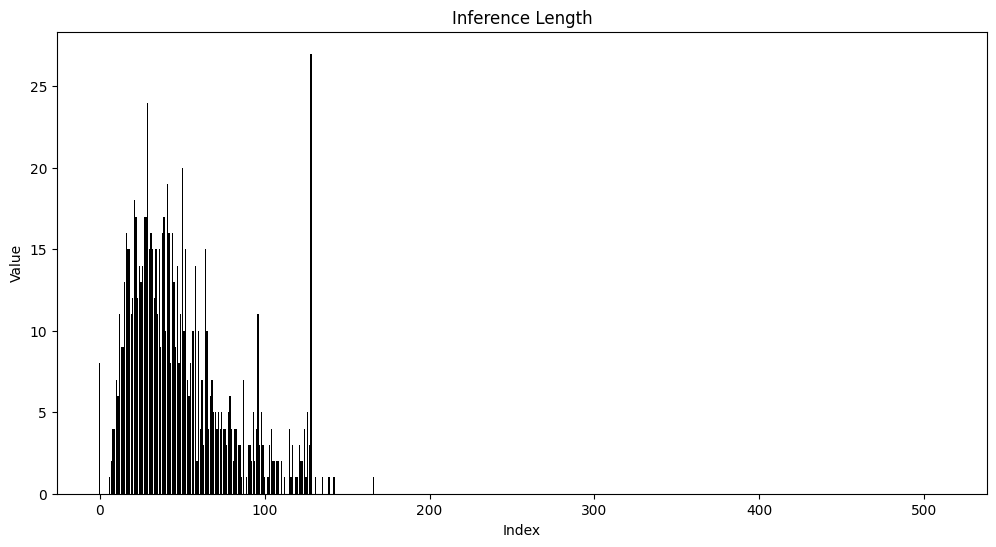

In [91]:
import matplotlib.pyplot as plt
# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(t_l)), t_l, color='black')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Inference Length')
plt.show()
